In [1]:
# import 
import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import os, glob, joblib
from tqdm import tqdm
from datetime import datetime
import re


import warnings
warnings.filterwarnings('ignore')

---
## KLARF file parsing

In [9]:
dir_path = "/home/seon/workspace/project/anomaly_wafer_detection/klarfsample_v3/A"
file_path = os.path.join(dir_path, '*.001')
path_list = glob.glob(file_path)
path_list


['/home/seon/workspace/project/anomaly_wafer_detection/klarfsample_v3/A/MODIFY02-007.001']

In [10]:
# 실행할 때마다 한 줄씩 읽어오기
# readlines()로 한번에 시도하면, 용량이 큰 파일의 경우엔 out of memory 가능성.

def readfile(file_path):
    readlines = []
    with open(file_path, 'r') as f:
        i = 1
        while True:
            line = f.readline()
            if not line:
                break
            line = str(i) + ' ' + line
            readlines.append(line.strip('\n').strip(';').split(' '))
            i += 1    
    return readlines

readfile(path_list[0])

[['1', 'FileVersion', '1', '7'],
 ['2', 'FileTimestamp', '03-09-23', '15:14:04'],
 ['3', 'TiffSpec', '6.0', 'G', 'R'],
 ['4',
  'InspectionStationID',
  '"ADVANCED',
  'TECHNOLOGY',
  'INC"',
  '"M08A3D10"',
  '"M08A3D10"'],
 ['5', 'SampleType', 'WAFER'],
 ['6', 'ResultTimestamp', '03-09-23', '15:11:54'],
 ['7', 'LotID', '"MODIFY02"'],
 ['8', 'SampleSize', '1', '300'],
 ['9', 'SetupID', '"MI_MONITORING_TD5_K1.7"', '03-09-23', '15:11:54'],
 ['10', 'DeviceID', '"KIDTEST"'],
 ['11', 'StepID', '"WAFER', 'REFLOW', 'INSP3"'],
 ['12', 'SampleOrientationMarkType', 'NOTCH'],
 ['13', 'OrientationMarkLocation', 'DOWN'],
 ['14', 'DiePitch', '10525.961', '9559.127'],
 ['15', 'DieOrigin', '0.000', '0.000'],
 ['16', 'WaferID', '"07"'],
 ['17', 'Slot', '07'],
 ['18', 'SampleCenterLocation', '136837.492', '138607.340'],
 ['19', 'ClassLookup', '6'],
 ['20', '100', '"ETC"'],
 ['21', '250', '"LSLV"'],
 ['22', '251', '"USLV"'],
 ['23', '253', '"COPL"'],
 ['24', '253', '"COPL"'],
 ['25', '250', '"MISSING"']

### KLARF file의 설비, 제품 및 시간에 대한 데이터 parsing

In [11]:
# KLARF file로부터 데이터 parsing
temp_df = pd.DataFrame()
fname = []
for i, fp in enumerate(path_list):
    dict_klarf = {}
    for line in readfile(fp):
        if not line[1].lstrip('-').isnumeric():
            dict_klarf[line[1]] = ' '.join(line[2:])
    fname.append(os.path.split(fp)[1].split('.')[0])
    temp = pd.DataFrame(dict_klarf, index=[i])
    temp_df = pd.concat([temp_df, temp])

temp_df.columns = temp_df.columns.str.lower()
temp_df['filename'] = fname
cols = ['filename']
cols.extend(temp_df.columns[:-1])

temp_df = temp_df[cols]
temp_df.head(3)

,filename,fileversion,filetimestamp,tiffspec,inspectionstationid,sampletype,resulttimestamp,lotid,samplesize,setupid,...,samplediemap,inspectiontest,sampletestplan,areapertest,tifffilename,defectrecordspec,defectlist,summaryspec,summarylist,endoffile
0,MODIFY02-007,1 7,03-09-23 15:14:04,6.0 G R,"""ADVANCED TECHNOLOGY INC"" ""M08A3D10"" ""M08A3D10""",WAFER,03-09-23 15:11:54,"""MODIFY02""",1 300,"""MI_MONITORING_TD5_K1.7"" 03-09-23 15:11:54",...,616,1,616,61981302784.000,MODIFY02-007.tif,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,


In [12]:
# unique값이 1인 columns 정리
singleCols = []
for col in temp_df.columns:
    if len(temp_df[col].unique()) == 1:
        singleCols.append(col)
        print('==='*20)
        print(col)
        print(temp_df[col].unique())
    
# 위에서 정리한 columns에 이미 dataframe으로 만든 DefectList, SummaryList columns 추가
singleCols.extend(["defectlist", "summarylist"])

filename
['MODIFY02-007']
fileversion
['1 7']
filetimestamp
['03-09-23 15:14:04']
tiffspec
['6.0 G R']
inspectionstationid
['"ADVANCED TECHNOLOGY INC" "M08A3D10" "M08A3D10"']
sampletype
['WAFER']
resulttimestamp
['03-09-23 15:11:54']
lotid
['"MODIFY02"']
samplesize
['1 300']
setupid
['"MI_MONITORING_TD5_K1.7" 03-09-23 15:11:54']
deviceid
['"KIDTEST"']
stepid
['"WAFER REFLOW INSP3"']
sampleorientationmarktype
['NOTCH']
orientationmarklocation
['DOWN']
diepitch
['10525.961 9559.127']
dieorigin
['0.000 0.000']
waferid
['"07"']
slot
['07']
samplecenterlocation
['136837.492 138607.340']
classlookup
['6']
samplediemap
['616']
inspectiontest
['1']
sampletestplan
['616']
areapertest
['61981302784.000']
tifffilename
['MODIFY02-007.tif']
defectrecordspec
['17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZE DEFECTAREA DSIZE CLASSNUMBER TEST CLUSTERNUMBER ROUGHBINNUMBER FINEBINNUMBER REVIEWSAMPLE IMAGECOUNT IMAGELIST']
defectlist
['']
summaryspec
['5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE']
summaryli

In [13]:
selectCols = [
    "filename",
    "filetimestamp",
    "inspectionstationid",
    "resulttimestamp",
    "lotid",
    "deviceid",
    "setupid",
    "stepid",
    "tifffilename",
    "waferid",
    "slot"
    ]
# 특정 columns만 추출
temp_df = temp_df[selectCols]

In [14]:
# column 비교 후 제거 함수
# 보존할 column = col1
# 제거할 column = col2
def eliminate(df, col1, col2):
    '''
    col1: 남길 컬럼
    col2: 제거할 컬럼
    '''
    if df[df[col1] != df[col2]].size == 0:
        df.drop(columns=col2, inplace=True)
        print(f'"{col2}" Column 제거됨.')
    return df

# FileTimestamp column과 ResultTimestamp column이 동일하면 해당 컬럼 삭제
temp_df = eliminate(temp_df, "filetimestamp", "resulttimestamp")
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,MODIFY02-007,03-09-23 15:14:04,"""ADVANCED TECHNOLOGY INC"" ""M08A3D10"" ""M08A3D10""",03-09-23 15:11:54,"""MODIFY02""","""KIDTEST""","""MI_MONITORING_TD5_K1.7"" 03-09-23 15:11:54","""WAFER REFLOW INSP3""",MODIFY02-007.tif,"""07""",07


In [15]:
# temp_df의 FileTimestamp를 datetime형으로 변환
# 현재 %m-%d-%y %H:%M:%S 형태로 되어있음. 이를 %Y-%m-%d %H:%M:%S

temp_df.filetimestamp = temp_df.filetimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,MODIFY02-007,2023-03-09 15:14:04,"""ADVANCED TECHNOLOGY INC"" ""M08A3D10"" ""M08A3D10""",03-09-23 15:11:54,"""MODIFY02""","""KIDTEST""","""MI_MONITORING_TD5_K1.7"" 03-09-23 15:11:54","""WAFER REFLOW INSP3""",MODIFY02-007.tif,"""07""",07


In [16]:
# InspectionStationID column
print(temp_df.inspectionstationid.unique())

# A3D01, A3D02로 요약할 수 있음.
temp_df.inspectionstationid = temp_df.inspectionstationid.apply(lambda x: x.strip('"').split('" "')[-1])
temp_df.head(3)

['"ADVANCED TECHNOLOGY INC" "M08A3D10" "M08A3D10"']


,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,"""MODIFY02""","""KIDTEST""","""MI_MONITORING_TD5_K1.7"" 03-09-23 15:11:54","""WAFER REFLOW INSP3""",MODIFY02-007.tif,"""07""",07


In [17]:
# # "LotID", "DeviceID", "StepID", "WaferID" columns에 대해 " " 제거
# temp_df[["LotID", "DeviceID", "StepID", "WaferID"]] = \
#     temp_df[["LotID", "DeviceID", "StepID", "WaferID"]].applymap(lambda x: x.strip(' "'))
# temp_df.head(3)
# 모든 columns에 대해 (") 제거
temp_df[["setupid", "lotid", "deviceid", "stepid", "waferid"]] = \
    temp_df[["setupid", "lotid", "deviceid", "stepid", "waferid"]].applymap(lambda x: x.replace('"',''))
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,MODIFY02-007.tif,07,07


In [18]:
# WaferID column과 Slot column이 동일한지 확인.
# 동일하면 Slot column 제거
# 동일하지 않다면, Fab에 문제가 생긴것..

temp_df = eliminate(temp_df, "waferid", "slot")
temp_df.head(3)

"slot" Column 제거됨.


,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,MODIFY02-007.tif,07


In [19]:
# SetupID column에서 timestamp가 FileTimestamp와 일치하는지 확인.
# 완벽히 일치한다면 해당 timestamp만 제거.
if temp_df[temp_df.setupid.apply(lambda x: datetime.strptime(' '.join(x.split(" ")[1:]).strip(' '), "%m-%d-%y %H:%M:%S"))
        != temp_df.filetimestamp].size == 0:
    temp_df.setupid = temp_df.setupid.apply(lambda x: x.split(" ")[0])
    print('timestamp 제거됨.')
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,MODIFY02-007.tif,07


In [20]:
# 수정된 SetupID column에서 Metrology-Type이 StepID와 일치하는지 확인.
# 완벽히 일치한다면 해당 column 제거.
temp_df = eliminate(temp_df, 'stepid', 'setupid')
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,MODIFY02-007.tif,07


In [21]:
# StepID column 종류 확인.
temp_df.stepid.unique()

array(['WAFER REFLOW INSP3'], dtype=object)

In [22]:
# StepID의 column 통일
temp_df.stepid = temp_df.stepid.apply(lambda x: x.upper())
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,tifffilename,waferid
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,MODIFY02-007.tif,07


In [23]:
# TiffFilename column이 FileName column과 일치하면 제거.
temp_df[["filename", "tifffilename"]] = temp_df[["filename", "tifffilename"]].applymap(lambda x: x.split('.')[0])
temp_df = eliminate(temp_df, "filename", "tifffilename")
temp_df.head(3)

"tifffilename" Column 제거됨.


,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,waferid
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,07


In [24]:
# WaferID에 LotID 정보 추가
temp_df.waferid = temp_df.lotid.apply(lambda x: re.split('\d+', x)[0]+re.split('\D+', x)[1]) + '-' + temp_df.waferid
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid,waferid
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,MODIFY02-07


In [25]:
# columns 이름 변경
# FileTimestamp -> Timestamp
# InspectionStationID -> MachineID
temp_df.rename(columns={'filetimestamp': 'timestamp',
                        'inspectionstationid': 'machineid'}, inplace=True)
temp_df.head(3)

,filename,timestamp,machineid,resulttimestamp,lotid,deviceid,setupid,stepid,waferid
0,MODIFY02-007,2023-03-09 15:14:04,M08A3D10,03-09-23 15:11:54,MODIFY02,KIDTEST,MI_MONITORING_TD5_K1.7 03-09-23 15:11:54,WAFER REFLOW INSP3,MODIFY02-07


In [27]:
# columns 순서 변경
newcols = ['filename', 'lotid', 'waferid', 'timestamp', 'machineid', 'stepid', 'deviceid']
temp_df = temp_df[newcols]
temp_df.head(3)

,filename,lotid,waferid,timestamp,machineid,stepid,deviceid
0,MODIFY02-007,MODIFY02,MODIFY02-07,2023-03-09 15:14:04,M08A3D10,WAFER REFLOW INSP3,KIDTEST


In [28]:
# timestamp 순으로 정렬
temp_df = temp_df.sort_values('timestamp').reset_index(drop=True)
temp_df.head(3)

,filename,lotid,waferid,timestamp,machineid,stepid,deviceid
0,MODIFY02-007,MODIFY02,MODIFY02-07,2023-03-09 15:14:04,M08A3D10,WAFER REFLOW INSP3,KIDTEST


### Wafer Map Visuallization

In [22]:
# Wafer Map Frame을 생성하기 위한 좌표 추출
readlines = readfile(file_path[0])
cnt = 0
for line in readlines:
    if line[1] == 'SampleDieMap':
        firstRow = int(line[0])
        cnt += 1
    elif line[1] == 'SampleTestPlan' and cnt == 1:
        lastRow = int(line[0]) - 3
    elif line[1] == 'SampleTestPlan' and cnt == 0:
        firstRow = int(line[0])
    elif line[1] == 'AreaPerTest' and cnt == 0:
        lastRow = int(line[0]) - 2

wafer_x_coordinate = np.array([int(line[1]) for line in readlines[firstRow:lastRow+1]])
wafer_y_coordinate = np.array([int(line[2]) for line in readlines[firstRow:lastRow+1]])

wafer_x_coordinate += np.array([1-min(wafer_x_coordinate)]*len(wafer_x_coordinate))
wafer_y_coordinate += np.array([1-min(wafer_y_coordinate)]*len(wafer_y_coordinate))

x_min, x_max = min(wafer_x_coordinate), max(wafer_x_coordinate)
y_min, y_max = min(wafer_y_coordinate), max(wafer_y_coordinate)

print(f'x_min: {x_min}, x_max: {x_max}')
print(f'y_min: {y_min}, y_max: {y_max}')

base_wafer = np.zeros([x_max+2, y_max+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

x_min: 1, x_max: 24
y_min: 1, y_max: 26


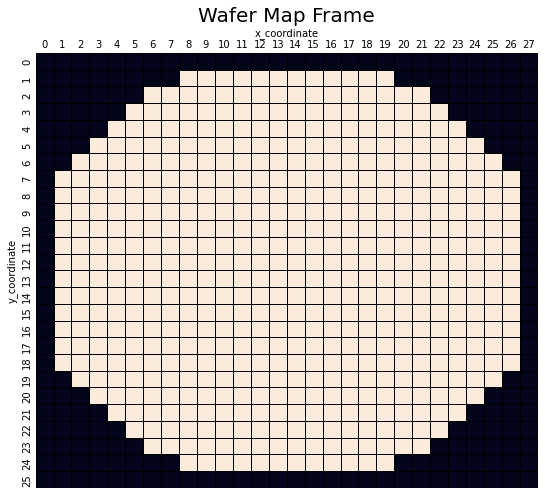

In [23]:
def visualization_wafer(map, size, title):
    plt.figure(figsize=(size+1,size))
    ax = sns.heatmap(map, linewidths=1, linecolor='black', cbar=False)
    plt.xlabel("x_coordinate")
    plt.ylabel("y_coordinate")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.title(title, fontsize=20)
    plt.show()
    
visualization_wafer(base_wafer, 8, "Wafer Map Frame")

In [24]:
# DefectList를 dataframe으로 변환.
defectList = []
for fp in tqdm(file_path):
    readlines = readfile(fp)
    for line in readlines:
        if line[1] == 'DefectList':
            defectRow = int(line[0])
        elif line[1] == 'SummarySpec':
            defectRowEND = int(line[0]) - 1
        else:
            continue
        
    defectCols = ['FILE']
    defectCols.extend(readlines[defectRow-2][3:])
    
    if readlines[defectRow][1].isnumeric():
        for line in readlines[defectRow:defectRowEND]:
            if len(line) == 18:
                temp = [os.path.split(fp)[1]]
                temp.extend(line[1:])
                defectList.append(temp)
    else:
        temp = [os.path.split(fp)[1]]
        temp.extend(np.zeros(17).tolist())
        defectList.append(temp)

defect_df = pd.DataFrame(data=defectList, columns=defectCols)
defect_df[["XINDEX", "YINDEX"]] = defect_df[["XINDEX", "YINDEX"]].astype('int')
defect_df.head()

100%|██████████| 1000/1000 [00:00<00:00, 3299.99it/s]


,FILE,DEFECTID,XREL,YREL,XINDEX,YINDEX,XSIZE,YSIZE,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST
0,AS10330WP_AS10330-14_01-01-23_83.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AS10103S1_AS10103-14_01-06-23_578.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC10022T_AC10022-02_01-07-23_780.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS10016TK_AS10016-17_01-07-23_731.001,1,1.5e+01,2.826e+03,2,1,499.077,502.606,0,0.000000,232,1,0,100,0,0,2,2
4,AC10010S1_AC10010-07_01-03-23_297.001,1,5.98e+03,5.289e+03,8,2,506.242,488.036,0,0.000000,232,1,0,100,0,0,2,2


In [25]:
# defect_df의 FILE columns 변경
defect_df.FILE = defect_df.FILE.apply(lambda x: x.split('.')[0])

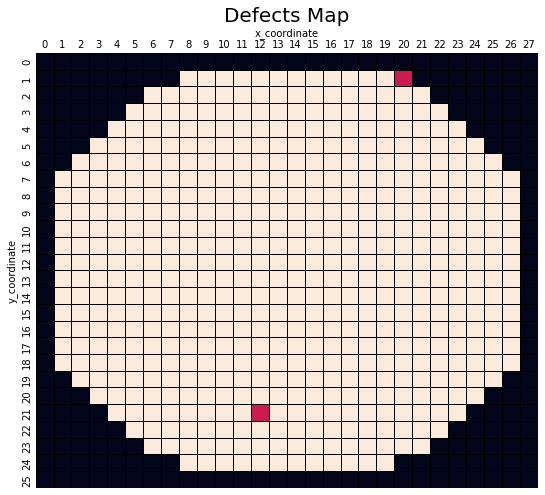

In [26]:
# defect 시각화
defectMaps=[]
for fp in file_path:
    base = base_wafer.copy()
    filename = os.path.split(fp)[1]
    defect_x = defect_df[defect_df.FILE == filename.split('.')[0]][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename.split('.')[0]][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[55],8, "Defects Map")

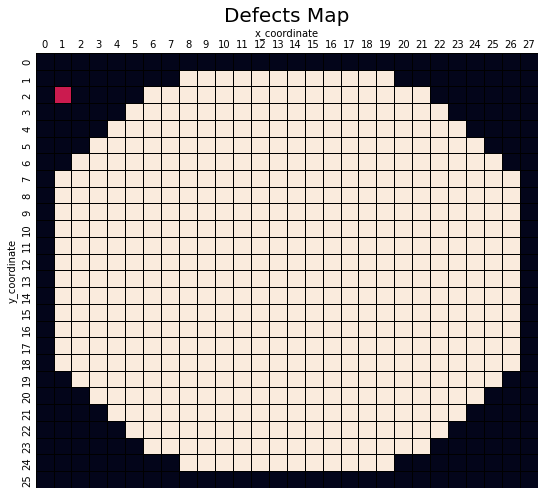

In [27]:
# defect가 wafer 영역 밖에서 표현되는 경우가 존재.
visualization_wafer(defectMaps[3],8, "Defects Map")

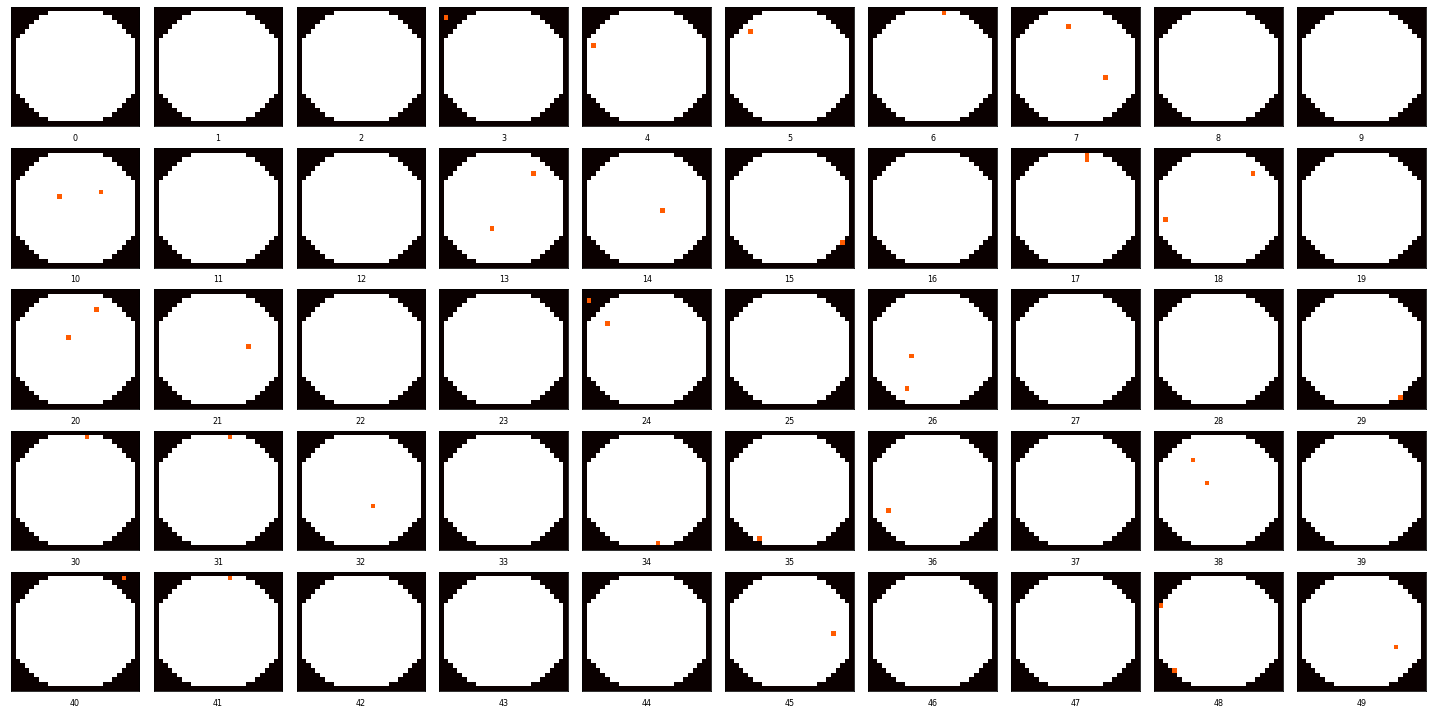

In [28]:
# 다중 wafer 시각화 (단순 추이를 보기 위함.)
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(20,10))
ax = ax.ravel(order='C')
for i in range(50):
    ax[i].imshow(defectMaps[i], cmap=cm.hot)
    ax[i].set_xlabel(f'{i}', fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## 분석용 데이터 생성

In [29]:
temp_df.head()

,filename,lotid,waferid,timestamp,machineid,stepid,deviceid
0,AC10002SA_AC10002-01_01-01-23_1,AC10002SA,AC10002- 01,2023-01-01 04:10:00,A3D02,METROLOGY-TYPE-01,AC1
1,AS10001T_AS10001-01_01-01-23_2,AS10001T,AS10001- 01,2023-01-01 04:12:49,A3D01,METROLOGY-TYPE-01,AS1
2,AS10001T_AS10001-02_01-01-23_3,AS10001T,AS10001- 02,2023-01-01 04:38:19,A3D01,METROLOGY-TYPE-01,AS1
3,AC10002SA_AC10002-03_01-01-23_4,AC10002SA,AC10002- 03,2023-01-01 04:41:51,A3D02,METROLOGY-TYPE-01,AC1
4,AS10001T_AS10001-03_01-01-23_5,AS10001T,AS10001- 03,2023-01-01 04:55:52,A3D01,METROLOGY-TYPE-01,AS1


In [30]:
defect_df["map"] = defect_df[["XINDEX", "YINDEX"]].apply(list, axis=1)
defect_df.head(3)

,FILE,DEFECTID,XREL,YREL,XINDEX,YINDEX,XSIZE,YSIZE,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST,map
0,AS10330WP_AS10330-14_01-01-23_83,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"
1,AS10103S1_AS10103-14_01-06-23_578,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"
2,AC10022T_AC10022-02_01-07-23_780,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"


In [31]:
def appendFn(*listset):
    lst = []
    for list_ in listset:
        lst.append(list_)
    return lst

defect_temp = defect_df.groupby(['FILE'])["map"].apply(appendFn).reset_index()
defect_temp.map = defect_temp.map.apply(lambda x: np.array(x).squeeze(0))
defect_temp

,FILE,map
0,AC10001TA_AC10001-01_01-01-23_41,"[[24, 20]]"
1,AC10001TA_AC10001-02_01-01-23_43,"[[15, 17]]"
2,AC10001TA_AC10001-03_01-01-23_45,"[[0, 0]]"
3,AC10001TA_AC10001-04_01-01-23_47,"[[0, 0]]"
4,AC10001TA_AC10001-05_01-01-23_49,"[[16, 21]]"
...,...,...
995,AS20300S_AS20300-21_01-07-23_690,"[[0, 0]]"
996,AS20300S_AS20300-22_01-07-23_692,"[[0, 0]]"
997,AS20300S_AS20300-23_01-07-23_693,"[[8, 5]]"
998,AS20300S_AS20300-24_01-07-23_695,"[[0, 0]]"


In [32]:
df = pd.merge(temp_df, defect_temp, how='inner', left_on='filename', right_on='FILE').drop(columns=["FILE", "filename"])
df.head()

,lotid,waferid,timestamp,machineid,stepid,deviceid,map
0,AC10002SA,AC10002- 01,2023-01-01 04:10:00,A3D02,METROLOGY-TYPE-01,AC1,"[[0, 0]]"
1,AS10001T,AS10001- 01,2023-01-01 04:12:49,A3D01,METROLOGY-TYPE-01,AS1,"[[16, 15]]"
2,AS10001T,AS10001- 02,2023-01-01 04:38:19,A3D01,METROLOGY-TYPE-01,AS1,"[[0, 0]]"
3,AC10002SA,AC10002- 03,2023-01-01 04:41:51,A3D02,METROLOGY-TYPE-01,AC1,"[[0, 0]]"
4,AS10001T,AS10001- 03,2023-01-01 04:55:52,A3D01,METROLOGY-TYPE-01,AS1,"[[0, 0]]"
